In [3]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
from scipy.linalg import logm, expm
from qiskit.quantum_info import Operator, state_fidelity
from qiskit import QuantumCircuit
from qiskit_aer import StatevectorSimulator, Aer
from qiskit.circuit.library import QFT
from qiskit.visualization import plot_histogram

from tools.classical import *
from tools.quantum import *

def brute_prepare_gaussian_state(num_energy_bits: int, sigma: float) -> QuantumCircuit:
    """An early implementation for low number of energy register qubits. For more qubits we would use QSVT maybe."""
    
    # Time labels in computational basis
    decimal_time_labels = list(range(2**(num_energy_bits - 1)))
    decimal_time_labels.extend(list(range(- 2**(num_energy_bits - 1), 0)))
    
    gauss_amplitude = lambda decimal_time: np.exp(-(decimal_time ** 2) / (4 * sigma ** 2))
    amplitudes = [gauss_amplitude(decimal_time) for decimal_time in decimal_time_labels]
    # Normalize 
    amplitudes = amplitudes / np.linalg.norm(amplitudes)
    print(amplitudes)
    
    prep_circ = QuantumCircuit(num_energy_bits, name="gauss")
    prep_circ.initialize(amplitudes, range(num_energy_bits))
    
    return prep_circ

def signed_order_counts(counts: dict, num_energy_bits: int) -> dict:
    bitstrings_pos = [bin(i)[2:].zfill(num_energy_bits - 1) for i in range(2**(num_energy_bits - 1))]
    bitstrings_pos = ['0' + bitstring for bitstring in bitstrings_pos]
    bitstrings_neg = [bin(i)[2:].zfill(num_energy_bits - 1) for i in range(2**(num_energy_bits - 1))]
    bitstrings_neg = ['1' + bitstring for bitstring in bitstrings_neg]
    bitstrings_ordered = bitstrings_neg + bitstrings_pos
    for bitstring in bitstrings_ordered:
        if bitstring not in counts.keys():
            counts[bitstring] = 0
    counts_ordered = {bitstrings_ordered[i]: counts[bitstrings_ordered[i]] 
                    for i in range(len(bitstrings_ordered)) if bitstrings_ordered[i] in counts.keys()}
    return counts_ordered

In [ ]:
sigma = 5
num_energy_bits = 6
num_labels = 2**num_energy_bits

N_labels = np.arange(num_labels / 2, dtype=int)
N_labels_neg = np.arange(- num_labels / 2, 0, dtype=int)
N_labels = np.concatenate((N_labels, N_labels_neg))
# time_labels = np.array(N_labels) / num_labels

gauss = lambda t: np.exp(-(t ** 2) / (4 * sigma ** 2))
gauss_values0 = np.array([gauss(n) for n in N_labels])
gauss_normalization0 = np.sqrt(np.sum([np.sqrt(np.abs(gauss(n))**2) for n in N_labels]))

### Fourier transform of Gaussian

In [13]:

qr_energy = QuantumRegister(num_energy_bits, name="qr_w")
cr_energy = ClassicalRegister(num_energy_bits, name="cr_w")
circ = QuantumCircuit(qr_energy, cr_energy)
gauss = brute_prepare_gaussian_state(num_energy_bits, sigma)

circ.compose(gauss, qr_energy, inplace=True)
circ.measure(qr_energy, cr_energy)
tr_circ = transpile(circ, basis_gates=['u', 'cx'], optimization_level=3)

simulator = Aer.get_backend('statevector_simulator')
shots = 10000
job = simulator.run(tr_circ, shots=shots)
counts = job.result().get_counts()
counts_ordered = signed_order_counts(counts, num_energy_bits)
print(counts_ordered)

[2.82468505e-01 2.79657896e-01 2.71392756e-01 2.58156775e-01
 2.40703782e-01 2.19986693e-01 1.97071589e-01 1.73047661e-01
 1.48943503e-01 1.25658393e-01 1.03914356e-01 8.42313396e-02
 6.69246297e-02 5.21209540e-02 3.97880675e-02 2.97719613e-02
 2.18361544e-02 1.56985297e-02 1.10625669e-02 7.64129473e-03
 5.17359113e-03 3.43345505e-03 2.23349373e-03 1.42413848e-03
 8.90089781e-04 5.45292493e-04 3.27445731e-04 1.92736185e-04
 1.11199105e-04 6.28859228e-05 3.48593828e-05 1.89408759e-05
 1.00877552e-05 1.89408759e-05 3.48593828e-05 6.28859228e-05
 1.11199105e-04 1.92736185e-04 3.27445731e-04 5.45292493e-04
 8.90089781e-04 1.42413848e-03 2.23349373e-03 3.43345505e-03
 5.17359113e-03 7.64129473e-03 1.10625669e-02 1.56985297e-02
 2.18361544e-02 2.97719613e-02 3.97880675e-02 5.21209540e-02
 6.69246297e-02 8.42313396e-02 1.03914356e-01 1.25658393e-01
 1.48943503e-01 1.73047661e-01 1.97071589e-01 2.19986693e-01
 2.40703782e-01 2.58156775e-01 2.71392756e-01 2.79657896e-01]
{'100000': 0, '100001':

<BarContainer object of 64 artists>

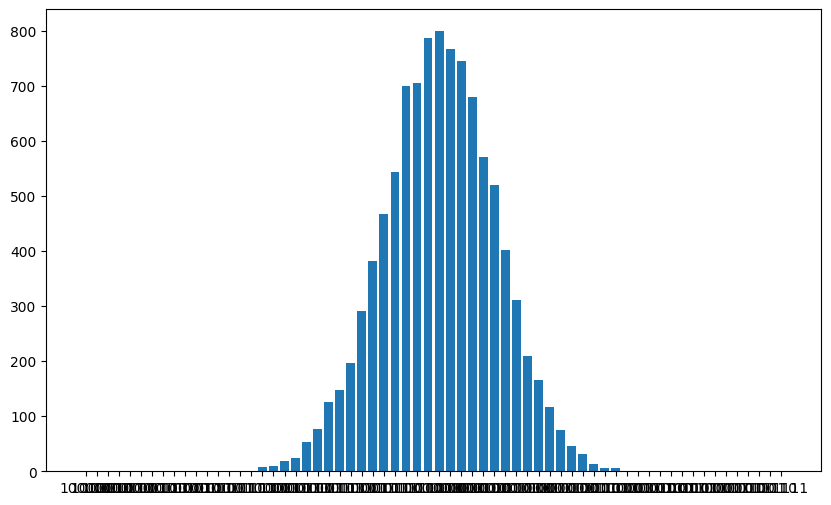

In [14]:
plt.figure(figsize=(10,6))
plt.bar(counts_ordered.keys(), counts_ordered.values())

Eigstate $7$

$\omega = -0.256$, $\sigma = 0$

The main contribution comes from $E = -0.375$ which is the bit state '1010'. But the actually jump energy is closer to '1100'

<BarContainer object of 16 artists>

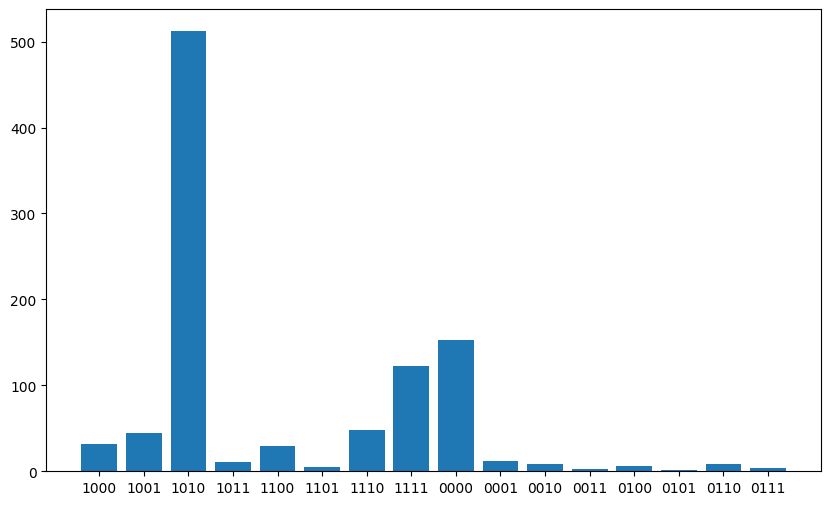

In [11]:
counts = {'1010': 512, '0000': 153, '1111': 123, '1110': 48, '1001': 45, '1000': 32, '1100': 29, '0001': 12, '1011': 11, '0010': 8, '0110': 8, '0100': 6, '1101': 5, '0111': 4, '0011': 3, '0101': 1}
counts_ordered = signed_order_counts(counts, num_energy_bits)
plt.figure(figsize=(10,6))
plt.bar(counts_ordered.keys(), counts_ordered.values())

$\sigma = 2$

<BarContainer object of 16 artists>

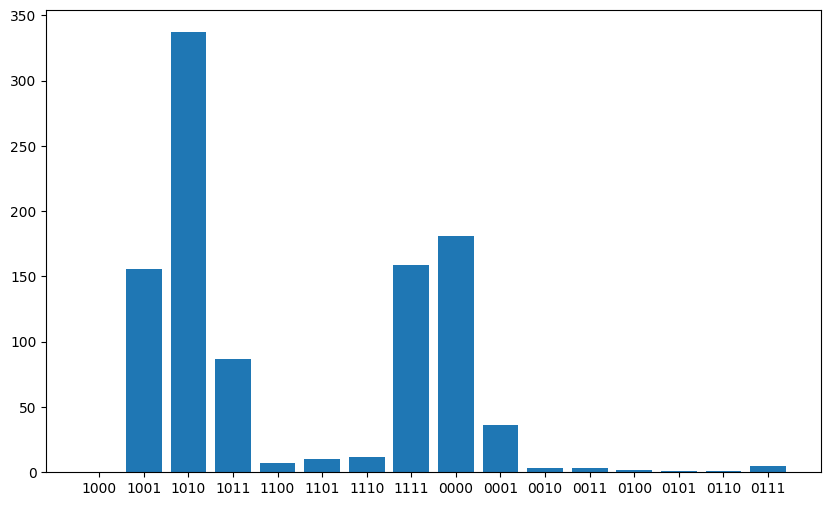

In [12]:
counts = {'1010': 337, '0000': 181, '1111': 159, '1001': 156, '1011': 87, '0001': 36, '1110': 12, '1101': 10, '1100': 7, '0111': 5, '0011': 3, '0010': 3, '0100': 2, '0110': 1, '0101': 1}
counts_ordered = signed_order_counts(counts, num_energy_bits)
plt.figure(figsize=(10,6))
plt.bar(counts_ordered.keys(), counts_ordered.values())

$\sigma = 3$

<BarContainer object of 16 artists>

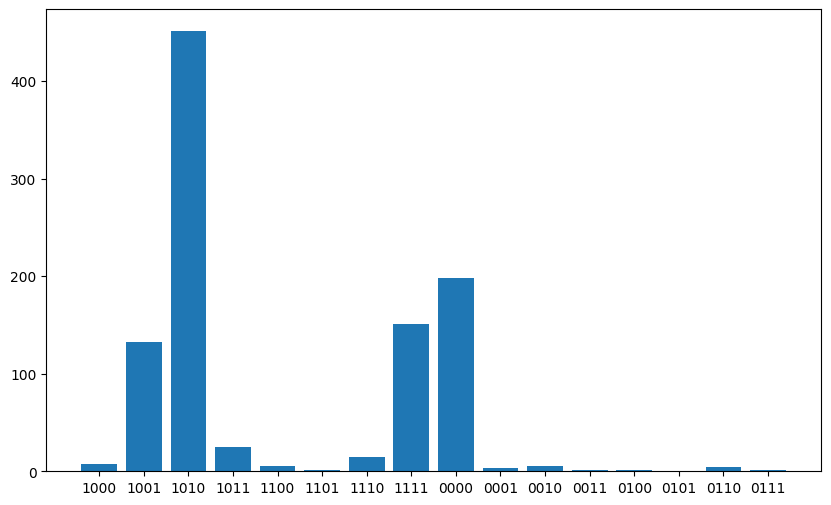

In [13]:
code = {'1010': 451, '0000': 198, '1111': 151, '1001': 132, '1011': 25, '1110': 15, '1000': 7, '0010': 5, '1100': 5, '0110': 4, '0001': 3, '0111': 1, '1101': 1, '0011': 1, '0100': 1}
code_ordered = signed_order_counts(code, num_energy_bits)
plt.figure(figsize=(10,6))
plt.bar(code_ordered.keys(), code_ordered.values())

$\sigma = 4$

<BarContainer object of 16 artists>

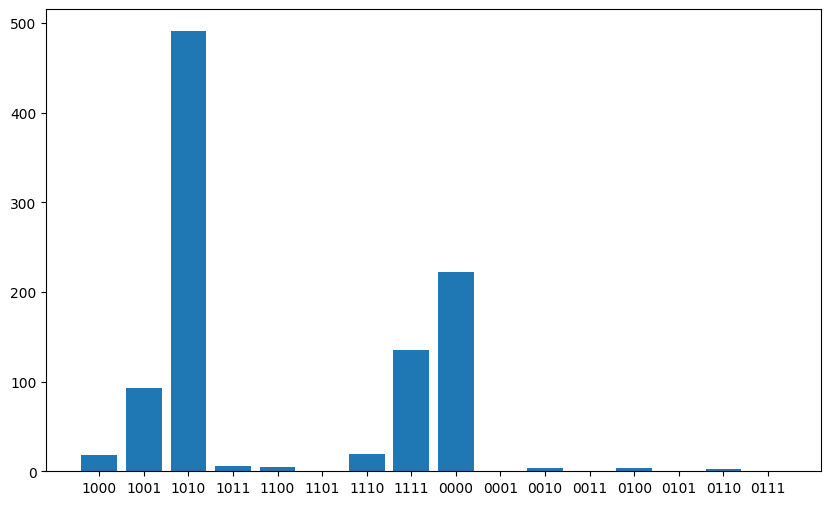

In [14]:
counts = {'1010': 491, '0000': 222, '1111': 135, '1001': 93, '1110': 19, '1000': 18, '1011': 6, '1100': 5, '0100': 4, '0010': 4, '0110': 3}
counts_ordered = signed_order_counts(counts, num_energy_bits)
plt.figure(figsize=(10,6))
plt.bar(counts_ordered.keys(), counts_ordered.values())

<BarContainer object of 32 artists>

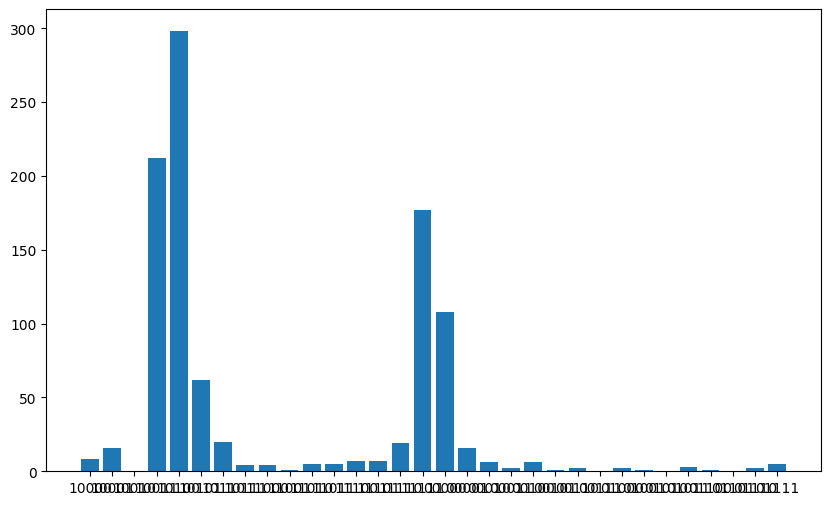

In [15]:
num_energy_bits = 5
counts = {'10100': 298, '10011': 212, '11111': 177, '00000': 108, '10101': 62, '10110': 20, '11110': 19, '00001': 16, '10001': 16, '10000': 8, '11100': 7, '11101': 7, '00100': 6, '00010': 6, '11010': 5, '11011': 5, '01111': 5, '11000': 4, '10111': 4, '01011': 3, '00011': 2, '01000': 2, '00110': 2, '01110': 2, '01100': 1, '01001': 1, '00101': 1, '11001': 1}
counts_ordered = signed_order_counts(counts, num_energy_bits)
plt.figure(figsize=(10,6))
plt.bar(counts_ordered.keys(), counts_ordered.values())

<BarContainer object of 64 artists>

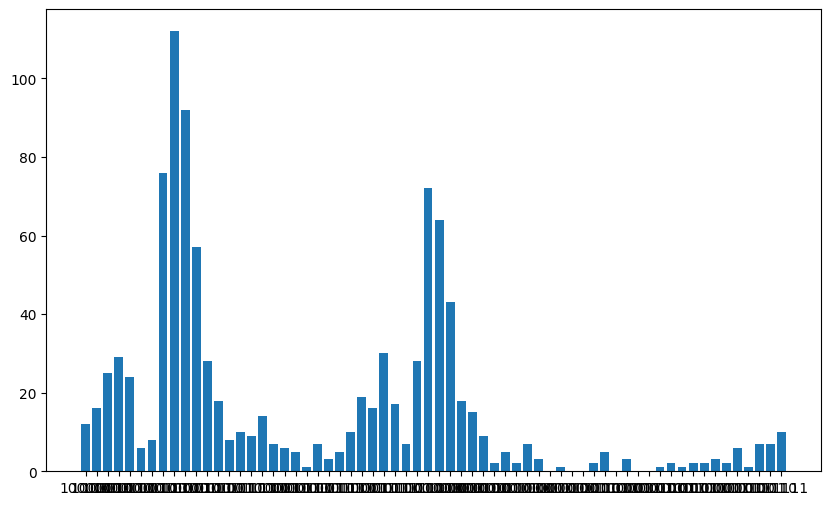

In [16]:
num_energy_bits = 6
counts = {'101000': 112, '101001': 92, '100111': 76, '111111': 72, '000000': 64, '101010': 57, '000001': 43, '111011': 30, '100011': 29, '111110': 28, '101011': 28, '100010': 25, '100100': 24, '111001': 19, '101100': 18, '000010': 18, '111100': 17, '100001': 16, '111010': 16, '000011': 15, '110000': 14, '100000': 12, '101110': 10, '011111': 10, '111000': 10, '000100': 9, '101111': 9, '101101': 8, '100110': 8, '110001': 7, '011101': 7, '011110': 7, '111101': 7, '001000': 7, '110101': 7, '011011': 6, '110010': 6, '100101': 6, '000110': 5, '110011': 5, '110111': 5, '001111': 5, '010001': 3, '001001': 3, '011001': 3, '110110': 3, '001110': 2, '011000': 2, '000111': 2, '010101': 2, '010111': 2, '000101': 2, '011010': 2, '110100': 1, '010100': 1, '010110': 1, '001011': 1, '011100': 1}
counts_ordered = signed_order_counts(counts, num_energy_bits)
plt.figure(figsize=(10,6))
plt.bar(counts_ordered.keys(), counts_ordered.values())
#* sigma = 4

<BarContainer object of 64 artists>

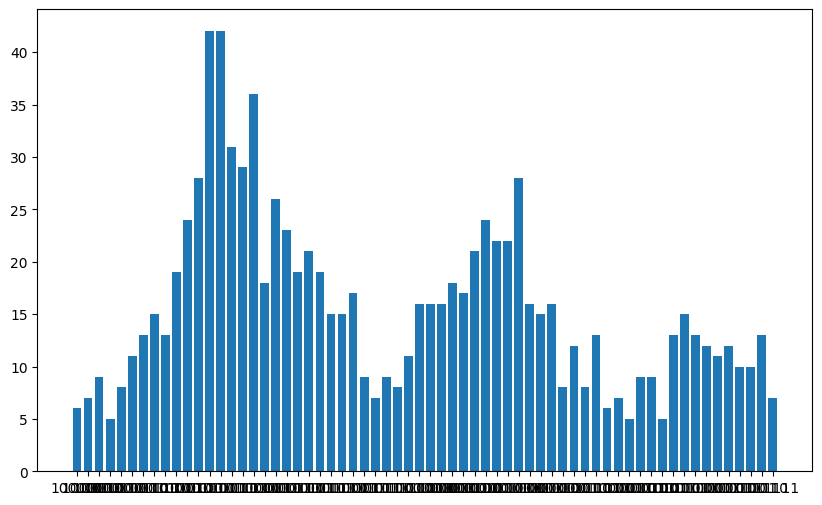

In [17]:
num_energy_bits = 6
counts = {'101101': 42, '101100': 42, '110000': 36, '101110': 31, '101111': 29, '001000': 28, '101011': 28, '110010': 26, '000101': 24, '101010': 24, '110011': 23, '000110': 22, '000111': 22, '110101': 21, '000100': 21, '110100': 19, '101001': 19, '110110': 19, '000010': 18, '110001': 18, '111001': 17, '000011': 17, '111111': 16, '000001': 16, '000000': 16, '001011': 16, '001001': 16, '111000': 15, '110111': 15, '100111': 15, '001010': 15, '010111': 15, '001111': 13, '011110': 13, '100110': 13, '011000': 13, '101000': 13, '010110': 13, '001101': 12, '011011': 12, '011001': 12, '111110': 11, '100101': 11, '011010': 11, '011100': 10, '011101': 10, '100010': 9, '111100': 9, '111010': 9, '010011': 9, '010100': 9, '100100': 8, '111101': 8, '001110': 8, '001100': 8, '111011': 7, '011111': 7, '100001': 7, '010001': 7, '100000': 6, '010000': 6, '010010': 5, '100011': 5, '010101': 5}
counts_ordered = signed_order_counts(counts, num_energy_bits)
plt.figure(figsize=(10,6))
plt.bar(counts_ordered.keys(), counts_ordered.values())
#* sigma = 1

<BarContainer object of 64 artists>

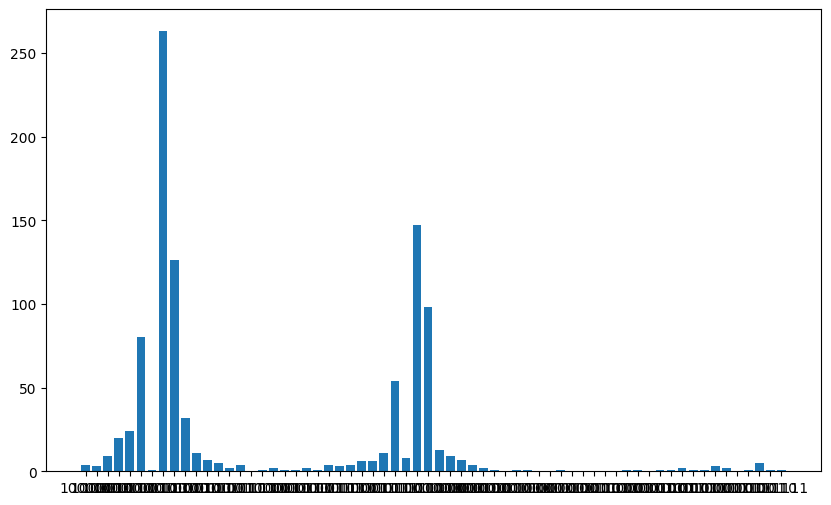

In [18]:
num_energy_bits = 6
counts = {'100111': 263, '111110': 147, '101000': 126, '111111': 98, '100101': 80, '111100': 54, '101001': 32, '100100': 24, '100011': 20, '000000': 13, '101010': 11, '111011': 11, '000001': 9, '100010': 9, '111101': 8, '000010': 7, '101011': 7, '111001': 6, '111010': 6, '011101': 5, '101100': 5, '100000': 4, '111000': 4, '000011': 4, '101110': 4, '110110': 4, '011001': 3, '110111': 3, '100001': 3, '101101': 2, '110001': 2, '000100': 2, '110100': 2, '011010': 2, '010110': 2, '110101': 1, '011100': 1, '100110': 1, '011111': 1, '110011': 1, '010010': 1, '011000': 1, '000101': 1, '001011': 1, '010100': 1, '000111': 1, '010101': 1, '011110': 1, '110010': 1, '001000': 1, '010111': 1, '010001': 1, '110000': 1}
counts_ordered = signed_order_counts(counts, num_energy_bits)
plt.figure(figsize=(10,6))
plt.bar(counts_ordered.keys(), counts_ordered.values())